# Jankbench benchmark on Android

Most devices today refresh their screens 60 times a second. If there’s an animation or transition running, or the user is scrolling, applications need to match the device’s refresh rate and put up a new picture, or frame, for each of those screen refreshes.
When one fails to meet this budget - 16.6 ms, the frame rate drops, and the content judders on screen. This is often referred to as jank, and it negatively impacts the user's experience.

This benchmark is used to count the jank frames for different types of activities: list and image list view fling, text render, text editing, etc. Also **ftraces** are captured during the benchmark run and represented at the end of the notebook.

In [1]:
from conf import LisaLogging
LisaLogging.setup()

2016-12-08 18:27:52,350 INFO    : root         : Using LISA logging configuration:
2016-12-08 18:27:52,350 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

# Support for trace events analysis
from trace import Trace
#from trace_analysis import TraceAnalysis

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    # Unlock device screen (assume no password required)
    target.execute('input keyevent 82')
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')
    
    # Configure screen to max brightness and no dimming
    Screen.set_brightness(target, percent=100)
    Screen.set_dim(target, auto=False)
    Screen.set_timeout(target, 60*60*10) # 10 hours should be enought for an experiment
    
    wload = Workload(te).get(te, 'Jankbench')
    te.ftrace.start()
    # Jankbench
    db_file, nrg_report = wload.run(te.res_dir, 'list_view', iterations=1, collect='ftrace')

    # Stop the required trace command
    te.ftrace.stop()
    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)

    # Reset screen brightness and auto dimming
    Screen.set_defaults(target)
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

    # return all the experiment data
    return {
       'dir'             : te.res_dir,
       'db_file'         : db_file,
       'nrg_report'      : nrg_report,
       'trace_file'      : trace_file,
    }

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'android',
    "board"        : 'pixel',
    
    # Device
    "device"       : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux",

    # Folder where all the results will be collected
    "results_dir" : "Jankbench_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2016-12-08 18:27:58,260 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2016-12-08 18:27:58,261 INFO    : TestEnv      : Loading custom (inline) target configuration
2016-12-08 18:27:58,261 INFO    : TestEnv      : External tools using:
2016-12-08 18:27:58,262 INFO    : TestEnv      :    ANDROID_HOME: /home/vagrant/lisa/tools/android-sdk-linux
2016-12-08 18:27:58,263 INFO    : TestEnv      :    CATAPULT_HOME: /home/vagrant/lisa/tools/catapult
2016-12-08 18:27:58,264 INFO    : TestEnv      : Loading board:
2016-12-08 18:27:58,264 INFO    : TestEnv      :    /home/vagrant/lisa/libs/utils/platforms/pixel.json
2016-12-08 18:27:58,266 INFO    : TestEnv      : Devlib modules to load: [u'bl', u'cpufreq']
2016-12-08 18:27:58,266 INFO    : TestEnv      : Connecting Android target [HT6670300102]
2016-12-08 18:27:58,267 INFO    : TestEnv      : Connection settings:
2016-12-08 18:27:58,267 INFO    : TestEnv      :    {'device': 'HT6670300102'}
2016-12-08 18:27:58,439 INFO    : android

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Jankbench - list view fling** experiment.

In [6]:
# Intialize Workloads for this test environment
results = experiment()

2016-12-08 18:28:09,603 INFO    : Screen       : Set brightness: 100%
2016-12-08 18:28:10,071 INFO    : Screen       : Dim screen mode: OFF
2016-12-08 18:28:10,551 INFO    : Screen       : Screen timeout: 36000 [s]
2016-12-08 18:28:12,578 WARNING : Workload     : Package [com.android.test.uibench] not installed
2016-12-08 18:28:12,581 WARNING : Workload     : Workload [UiBench] disabled
2016-12-08 18:28:12,583 INFO    : Workload     : Workloads available on target:
2016-12-08 18:28:12,585 INFO    : Workload     :   ['YouTube', 'Jankbench']
2016-12-08 18:28:12,587 INFO    : Workload     : Workloads available on target:
2016-12-08 18:28:12,588 INFO    : Workload     :   ['YouTube', 'Jankbench']
2016-12-08 18:28:17,475 INFO    : Screen       : Force manual orientation
2016-12-08 18:28:17,476 INFO    : Screen       : Set orientation: PORTRAIT
2016-12-08 18:28:18,672 INFO    : Jankbench    : am start -n "com.android.benchmark/.app.RunLocalBenchmarksActivity" --eia "com.android.benchmark.EXT

## Results collection

In [7]:
def import_db(path):
    # Selection of columns of interest
    COLS = ['_id', 'name', 'run_id', 'iteration', 'total_duration', 'jank_frame']
    data = []
    db = '{}/{}'.format(te.res_dir, 'BenchmarkResults')
    conn = sqlite3.connect(db)
    for row in conn.execute('SELECT {} FROM ui_results'.format(','.join(COLS))):
        row = ('sched', ) + row
        data.append(row)
    print "DB[ {} ]: {:6d} rows imported".format('sched', len(data))
    return pd.DataFrame(data, columns=['test', ] + COLS)

df = import_db(te.res_dir)

DB[ sched ]:   1631 rows imported


## Benchmark plots and statistics

All the plots below represent total duration statistics for all the frames, in different ways.

In [8]:
def overall_statistics(df):
    byname_test = df.groupby(['name','test']).total_duration.describe(percentiles=[0.9, 0.95, 0.99])
    stats = pd.DataFrame(byname_test)
    stats = stats.unstack()
    return stats

stats = overall_statistics(df)
stats

total_duration                                          \
                               count      mean       std       min       50%   
name            test                                                           
List View Fling sched         1631.0  5.362443  2.362088  2.769878  5.129805   

                                                                
                            90%       95%       99%        max  
name            test                                            
List View Fling sched  7.288264  7.610473  9.119775  81.748059

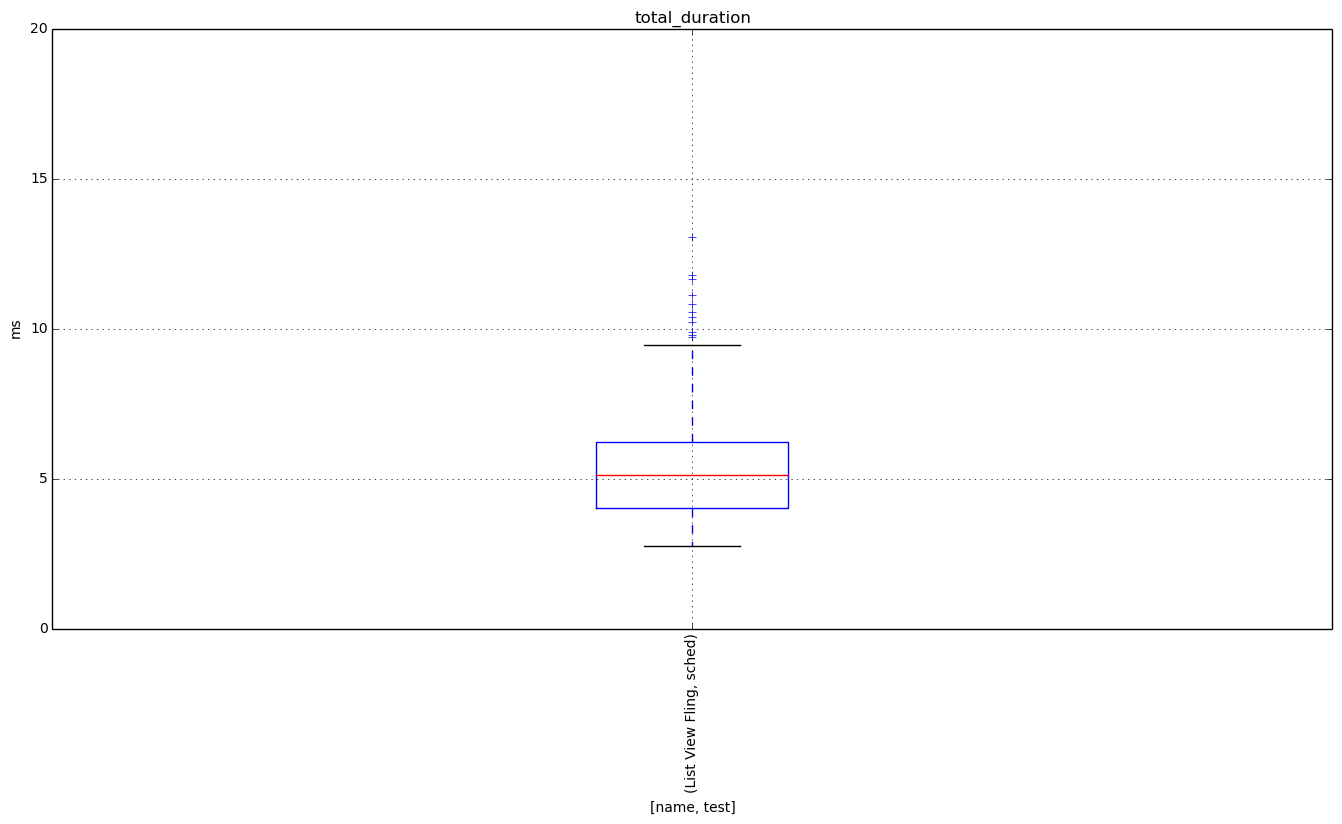

In [9]:
def total_duration_plot(data):
    fig, axes = plt.subplots(figsize=(16,8))
    bp = data.boxplot(by=['name','test'], column='total_duration', ax=axes, return_type='dict')
    fig.suptitle('')
    xlabels = [item.get_text() for item in axes.xaxis.get_ticklabels()]
    axes.set_xticklabels(xlabels, rotation=90)
    axes.set_ylim(0,20)
    axes.set_ylabel('ms');

total_duration_plot(data = df)

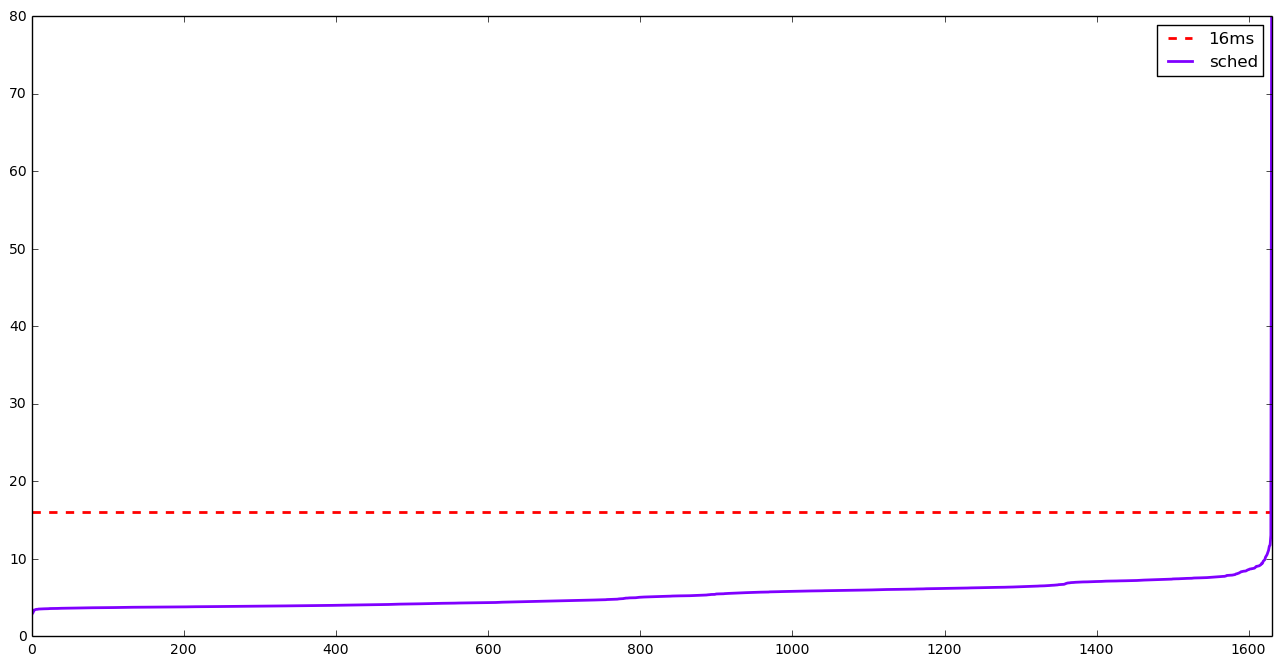

In [10]:
def total_duration_cumulative_distribution(df):
    fig, axes = plt.subplots()
    plt.axhline(y=16, linewidth=2, color='r', linestyle='--')
    colors = iter(cm.rainbow(np.linspace(0, 1, 1)))
    df = pd.DataFrame(sorted(df.total_duration))
    df.plot(
        figsize=(16,8),
        ax=axes,
        color=next(colors),
        linewidth=2,
        ylim=(0,80),
        legend=False);

    plt.legend(('16ms',) + tuple(['sched']), loc='best');
    
total_duration_cumulative_distribution(df)

## Traces - Latency analysis

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [11]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2016-12-08 18:29:50,731 INFO    : Trace        : Parsing FTrace format...
2016-12-08 18:30:13,701 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2016-12-08 18:30:22,283 INFO    : Trace        : Collected events spans a 45.779 [s] time interval
2016-12-08 18:30:22,285 INFO    : Trace        : Overutilized time: 7.302662 [s] (15.952% of trace time)
2016-12-08 18:30:22,285 INFO    : Trace        : Set plots time range to (0.000000, 45.779498)[s]
2016-12-08 18:30:22,286 INFO    : Analysis     : Registering trace analysis modules:
2016-12-08 18:30:22,291 INFO    : Analysis     :    tasks
2016-12-08 18:30:22,292 INFO    : Analysis     :    status
2016-12-08 18:30:22,296 INFO    : Analysis     :    frequency
2016-12-08 18:30:22,298 INFO    : Analysis     :    cpus
2016-12-08 18:30:22,300 INFO    : Analysis     :    latency
2016-12-08 18:30:22,303 INFO    : Analysis     :    idle
2016-12-08 18:30:22,303 INFO    : Analysis     :    functions
2016-12-08 18:30:22,306

2016-12-08 18:32:01,881 WARNING : Analysis     : Multiple PIDs for task named [droid.benchmark]
2016-12-08 18:32:01,914 WARNING : Analysis     :   20074 :  Binder:20062_1,droid.benchmark
2016-12-08 18:32:01,947 WARNING : Analysis     :   20076 :  Profile Saver,droid.benchmark
2016-12-08 18:32:01,981 WARNING : Analysis     :   20110 :  AsyncTask #1,droid.benchmark
2016-12-08 18:32:02,021 WARNING : Analysis     :   20082 :  RenderThread,droid.benchmark
2016-12-08 18:32:02,059 WARNING : Analysis     :   20085 :  AutomatorThread,droid.benchmark
2016-12-08 18:32:02,096 WARNING : Analysis     :   20086 :  FrameStatsColle,droid.benchmark
2016-12-08 18:32:02,135 WARNING : Analysis     :   20062 :  droid.benchmar,re-initialized>,main,droid.benchmark
2016-12-08 18:32:02,136 WARNING : Analysis     : Returning stats only for PID: 20074
2016-12-08 18:32:02,386 INFO    : Analysis     : Found:   871 WAKEUP latencies
2016-12-08 18:32:02,426 INFO    : Analysis     : Found:    69 PREEMPT latencies
2016-

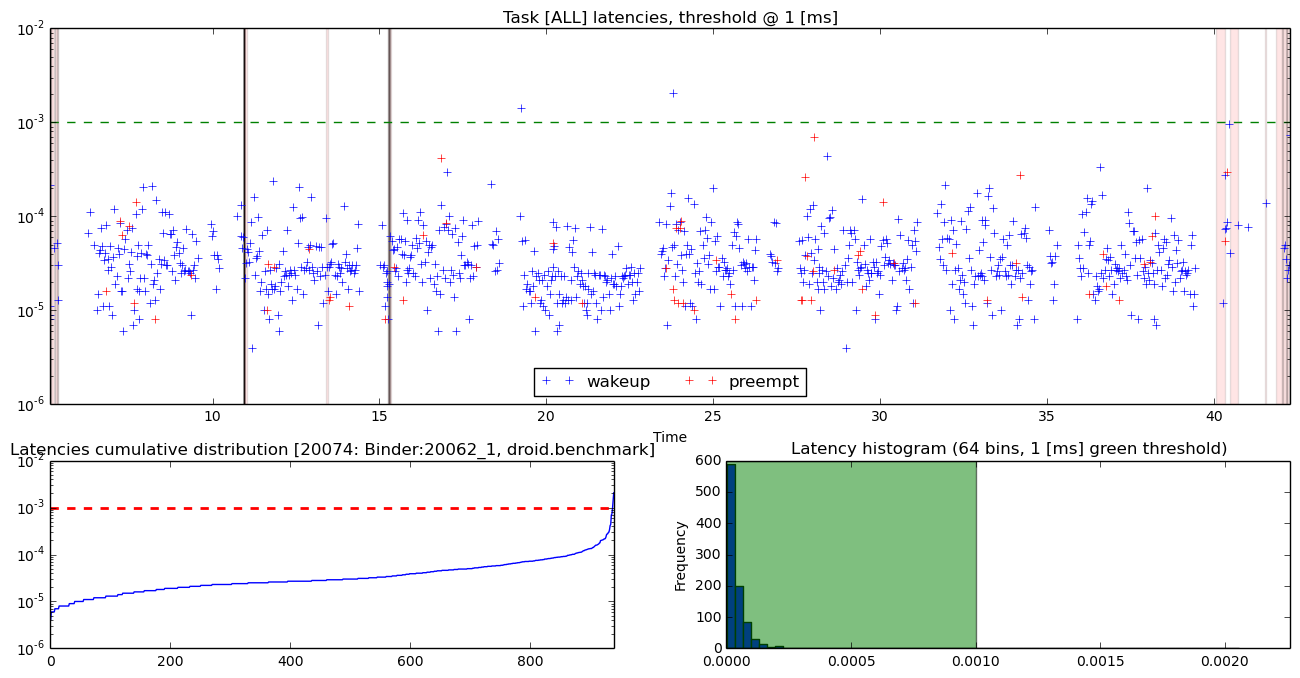

In [15]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('droid.benchmark')

2016-12-08 18:32:46,701 INFO    : Analysis     : LITTLE cluster average frequency: 1.122 GHz
2016-12-08 18:32:46,702 INFO    : Analysis     : big    cluster average frequency: 1.486 GHz


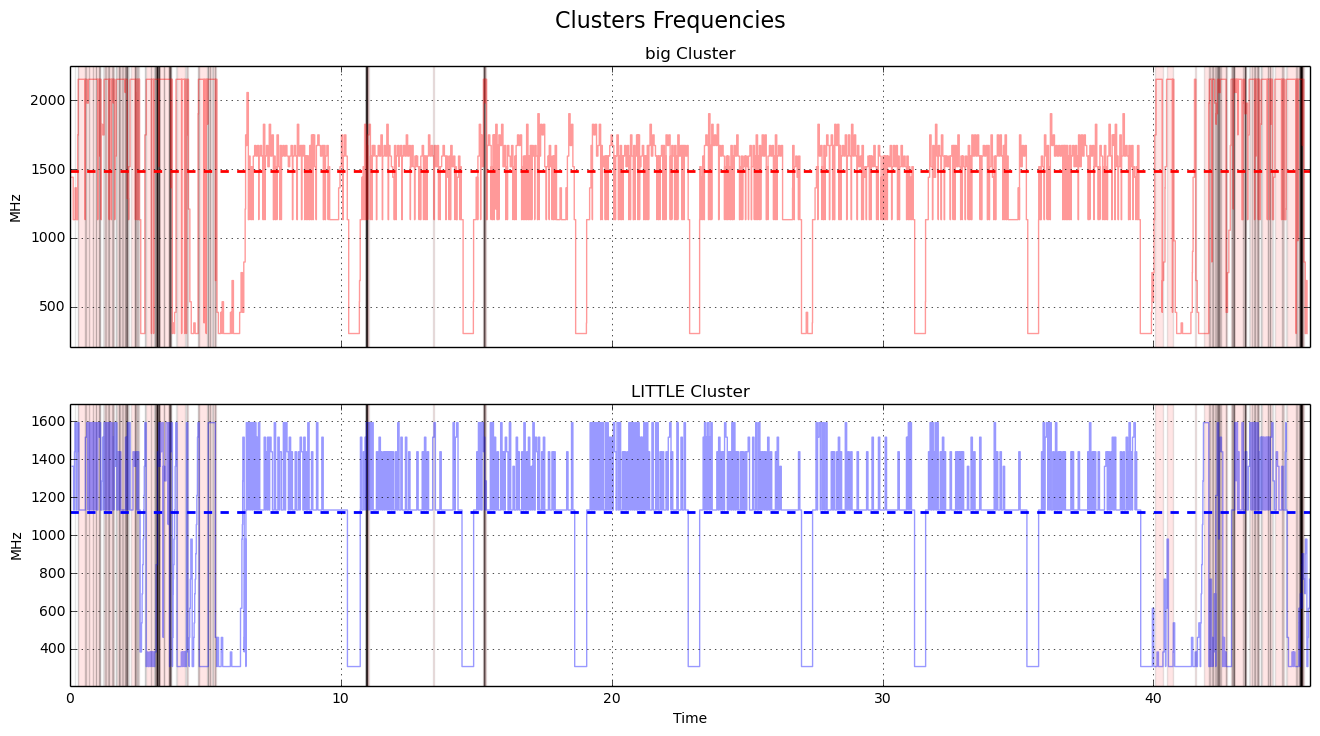

In [16]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass